# Setup and analysis

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, './scripts')
sys.path.insert(1, './FastBDT_git/FastBDT')
import plot_tools
from PyFastBDT import FastBDT
import tools
import os

In [54]:
# Importing reweighting libraries

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import ks_test
import plot_tools
from ks_test import ks_2samp_weighted 

import seaborn as sns # for correlation heatmap

# For hyperparameter optimization
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

from sklearn.metrics import accuracy_score

In [55]:
data_path = '/home/carlos/projects/Ayudantia/projects/fastbdt/data'
#data_path = tools.analysis_path(data_path)

In [56]:
RD = pd.read_csv(os.path.join(data_path, f'RD_Complete.csv')).query('5<=BMass<=5.7')
RD['label']=1
PHSP = pd.read_csv(os.path.join(data_path, f'PHSP_Complete.csv')).query('5<=BMass<=5.7')
PHSP['label']=0
PHSP['sW']=1

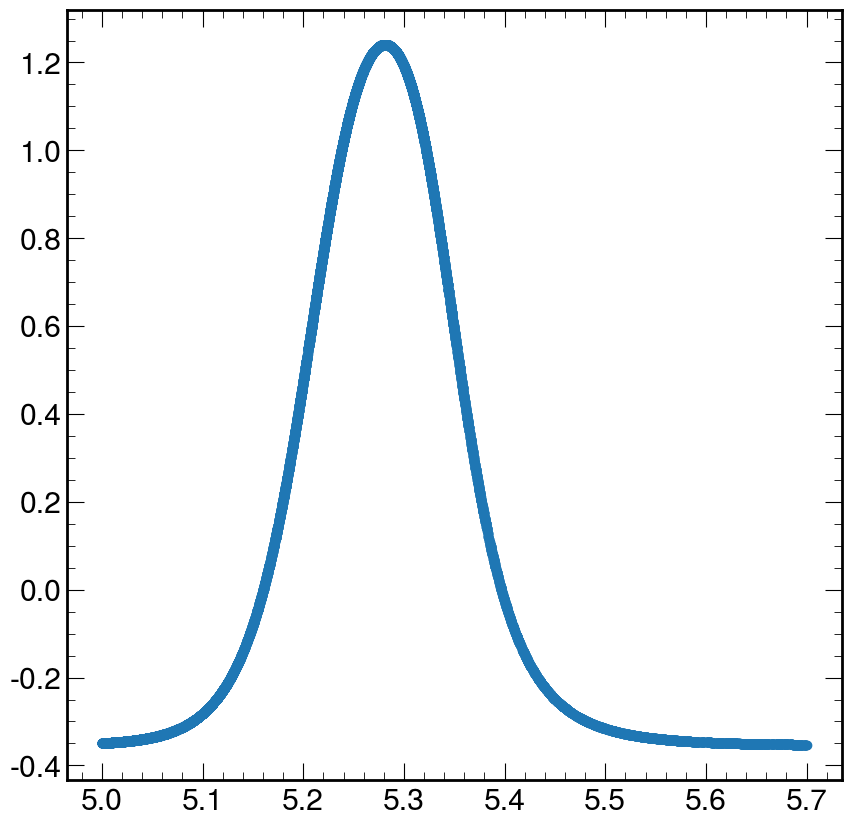

In [57]:
plt.scatter(RD.BMass, RD.sW)

xgb.__version__

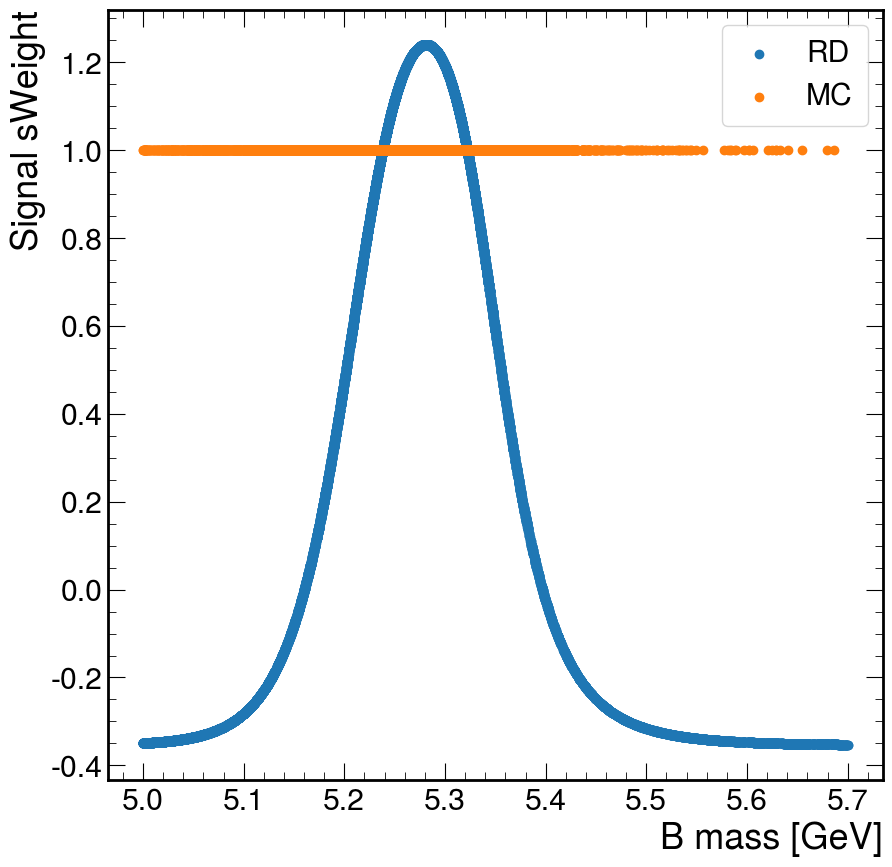

In [58]:
plt.scatter(RD.BMass, RD.sW, label='RD')
plt.scatter(PHSP.BMass, PHSP.sW, label='MC')
plt.xlabel('B mass [GeV]')
plt.ylabel('Signal sWeight')
plt.legend(frameon=True)

In [59]:
cols = ['mu1_pt', 'mu2_pt', 'kpt', 'cosA', 'fit_eta', 'mu1_IP_sig', 'mu2_IP_sig']
dataFrame = pd.concat([RD[cols+['label', 'sW']],
                       PHSP[cols+['label', 'sW']]])

# Functions

In [60]:
def print_weighted_hist_comparison(MC, RD, cols, weights, title="Hist comparison", 
                                   show_mc=True, num_bins=20, default_MC_w = 1, 
                                   mc_weight_col=None, range=None):
  """Plots histogram of initial MC data against RD, and reweighted MC data. 
  Multiple weights lists can be given to compare many re-weightings of MC data.
  RD and MC are expected to have a "W" weights column, if not found, assigns a default weights of 1 to a created column with this name.

  Parameters:
  MC (pandas.core.frame.DataFrame): Monte Carlo or simulated data
  RD (pandas.core.frame.DataFrame): Real data
  cols (list): Names of the columns to be used
  weights(list): Weights for MC data, can be an array of multiple weights lists with MC length
  title (string): Name template of histograms, prefix for all plots per variable
  show_mc (bool): Show MC histogram
  num_bins (int): Number of bins to display for plots
  default_MC_W = weights of the initial MC data.

  Returns:
  None
  """

  # MC = np.array(MC, dtype=float)
  # MC = MC[np.isfinite(MC)]
  # RD = RD[np.isfinite(RD)]
  COMP = MC.append(RD)
  # Create weights column if not found any
  if 'W' not in RD.columns:
      RD['W'] = 1
  if mc_weight_col:
    if mc_weight_col not in MC.columns:
      MC['W'] = 1
  # Plot per variable in columns
  i = 0
  print(range)
  if range == None:
    range = [None] * len(cols)
  for var in cols:
    # Creating the bins
    if range[i] == None:
      a = min(COMP[var])
      b = max(COMP[var])
    else:
      if range[i][0] == None: a = min(COMP[var])
      else: a = range[i][0]
      if range[i][1] == None: b = max(COMP[var])
      else: b = range[i][1]
    bins = np.histogram(np.hstack((a,b)), bins=num_bins)[1] #get the bin edges
    # Plotting the weighted RD data
    plt.hist(RD[var], bins=bins, alpha=0.5, label="Weighted RD", weights=RD.W, 
             density=True, color="gray", range=range[i])
    # Plotting weighted MC data
    if show_mc:
      plt.hist(MC[var], bins=bins, alpha=0.5, label="Weighted MC", histtype="step", 
               weights=MC[mc_weight_col], linewidth=2.5, density=True, range=range[i])
    # In case weights is a list of multiple MC weights, we plot for each weights list
    if isinstance(weights, list):
      for w in weights:
        #complete_weight = np.multiply(MC["W"], w["weight"])
        complete_weight = w["weight"]
        plt.hist(MC[var], bins=bins, alpha=0.75, label=w["title"], 
                 histtype="step", linewidth=2.5, weights=complete_weight, 
                 density=True, range = range[i])
    else:
      #complete_weight = np.multiply(MC["W"], weights)
      complete_weight = weights
      plt.hist(MC[var], bins=bins, alpha=0.9, label="MC xgb-reweighted", 
               histtype="step", linewidth=2.5, weights=complete_weight, 
               density=True, range = range[i])
    print(range[i])
    plt.legend()
    plt.title(title + " for var " + var)
    plt.show()
    i+=1

In [61]:
def hist_with_pulls(MC, RD, cols, weights=None, title="MC vs RD"):
  """Plots histogram of a weighted MC data against weighted RD including pulls. 
  This function uses plot_tools.compare_plot

  Parameters:
  MC (pandas.core.frame.DataFrame): Monte Carlo or simulated data
  RD (pandas.core.frame.DataFrame): Real data
  weights(list): MC data weights
  cols (list): Names of the columns to be used
  title (string): Name template of histograms, prefix for all plots per variable

  Returns:
  None
  """

  # If no "W" column is found, we assign weight=1 by default
  if 'W' not in RD.columns:
    RD['W'] = 1
  if 'W' not in MC.columns:
    MC['W'] = 1
  for var in cols:
    plot_tools.compare_plot(Data_Num = RD[var], 
                            Data_Den = MC[var], 
                            weights_Num=RD['W'], 
                            weights_Den=weights, 
                            label_Num = '1', 
                            label_Den = '0', 
                            title=title + " for " + var,
                            ks_t = True)

In [62]:
def ks_2samp_per_var(data, weights, cols):
  """Calculates the p-values for two weighted samples of data, separating label 1 from label 0.
  Uses the ks_2samp_weighted to calculate the values

  Parameters:
  data (Any): Merged MC and RD data with 'label' column
  weights (list): Weights for MC to be used in the p-value calculation
  cols (list): Names of the columns of which the p-value is to be known

  Returns:
  results (dict): Dictionary with the name of the columns as keys and the p-values as values
  """
  # MC = np.array(MC, dtype=float)
  # MC = MC[np.isfinite(MC)]
  # RD = RD[np.isfinite(RD)]

  results = {}
  print("ks_2samp_per_var data shape: ", data.query('label==0').shape)
  for var in cols:
    distance = ks_2samp_weighted(data.query('label==1')[var],
                            data.query('label==0')[var],
                            data.query('label==1')['W'],
                            weights)
    print(distance)
    results[var] = distance[1]
  return results

In [63]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, cbar_kws={"shrink": .70}, annot=True, annot_kws={"size": 35 / np.sqrt(len(correlations))}
                )
    plt.show();

## Iterative reweighting functions

In [64]:
def create_training_data(MC, RD, cols):
  """Creates the Training Data by merging the RD and MC data, using the given columns

  Parameters:
  MC (dataframe): MC data with weights "W" column and "label" column
  RD (dataframe): RD data with weights "W" column and "label" column
  cols (list): Names of the columns of which the p-value is to be known

  Returns:
  TRAIN_DATAmask (dataframe):  
  """
  RD_ = RD[cols+['label','W']]
  MC_ = MC[cols+['label','W']]

  print("MC_ lenght loc label=0", MC_.loc[MC_.label == 0].shape)

  TRAIN_DATA = MC_.append(RD_)
  #TRAIN_DATA=TRAIN_DATA[np.isfinite(TRAIN_DATA)]
  
  #TRAIN_DATAmask =TRAIN_DATA[ TRAIN_DATA.W>0]

  return TRAIN_DATA

In [65]:
def apply_weights(RD, MC, RD_w, MC_w=1):
  """Sets 'label' and 'W' columns for RD and MC data, given the weights for RD and MC data respectively

  Parameters:
  RD (dataframe): RD data
  MC (dataframe): MC data
  RD_w (list): RD weights to be applied, they should have the same lenght as the RD data
  MC_w (list): MC weights to be applied, they should have the same lenght as the MC data

  Returns:
  RD, MC: tuple of the new RD and MC dataframes with 'W' and 'label' columns
  """

  # Monte Carlo Data = Background
  # Weights of all events are set to 1
  MC['W'] = MC_w 
  MC['label'] = 0

  # Real Data = Signal
  # This data is the one wants to fit to the MC data
  RD['W'] = RD_w #RD.sW_sum
  RD['label'] = 1
  return RD, MC

In [66]:
# Function to generate the new weights

def xgb_weights(RD, MC, cols, train_data, optimize=True):

  """Creates a model with the given data and does hyperparameter optimization. 
  RD and MC data is required for the Bayesian optimization of hyperparameters.

  Parameters:
  RD (dataframe): RD data
  MC (dataframe): MC data
  cols (list): Names of the columns to be used
  train_data (dataframe): Merged RD and MC data used for training of the model
  optimize (bool): Indicates if hyperoptimization is to be used in the xgboost model

  Returns:
  weigths, model: Tuple of new weights for MC with lenght of the MC data and the trained xgboost model
  """
  model = xgb.XGBClassifier(objective='binary:logistic', 
                          use_label_encoder=False,
                          tree_method = 'gpu_hist',
                          gpu_id=0)

  if optimize:
    # Finding hyperparameters
    
    # Creating the hyperparameter dictionary
    b_dict = {}

    # The possible values are now given by the hyperopt hp function
    param_space_complete = {
              'max_leaves': hp.choice('max_leaves', np.arange(1, 100+1, dtype=int)),
              'max_depth': hp.choice('max_depth', np.arange(3, 10+1, dtype=int)),
              'learning_rate': hp.uniform('learning_rate', 0, 10),
              'reg_alpha': hp.uniform('reg_alpha', 0, 6),
              'reg_lambda': hp.uniform('reg_lambda', 0, 6),
              'min_child_weight': hp.uniform('min_child_weight', 0, 25),
              # 'colsample_bylevel': hp.uniform('colsample_bylevel', 0.7, 1),
              # 'colsample_bynode': hp.uniform('colsample_bynode', 0.7, 1),
              # 'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1),
              'gamma': hp.uniform('gamma', 0, 20),
                }
    
    best_hyperparams = fmin(fn = objective_complete,
                            space = param_space_complete,
                            algo = tpe.suggest,
                            max_evals = 100,
                            )
    
    max_leaves_s = np.arange(1, 100+1, dtype=int)
    max_depth_s = np.arange(3, 10+1, dtype=int)

    # Adding one so we get the value and not the index
    b_dict['max_leaves'] = max_leaves_s[best_hyperparams['max_leaves']]
    # Same for the max_depth
    b_dict['max_depth'] = max_depth_s[best_hyperparams['max_depth']]

    n_jobs = os.cpu_count()

    # Creating the model with the selected hyperparameters:

    model =xgb.XGBClassifier(objective='binary:logistic', 
                          use_label_encoder=False,
                          tree_method = 'gpu_hist',
                          gpu_id=0,
                          n_jobs=n_jobs,
                          max_leaves = best_hyperparams['max_leaves']+1,
                          max_depth = best_hyperparams['max_depth']+3,
                          learning_rate = best_hyperparams['learning_rate'],
                          reg_alpha = best_hyperparams['reg_alpha'],
                          reg_lambda = best_hyperparams['reg_lambda'],
                          min_child_weight = best_hyperparams['min_child_weight'],
                          #  colsample_bylevel = best_hyperparams['colsample_bylevel'],
                          #  colsample_bynode = best_hyperparams['colsample_bynode'],
                          #  colsample_bytree = best_hyperparams['colsample_bytree'],
                          gamma = best_hyperparams['gamma'],
                          )
    
  # Fitting the model
  model.fit(train_data[cols], 
          train_data.label, 
          sample_weight=train_data.W
          )
  
  # Calculating the probabilities of data being MC or RD
  MCprob, RDprob = model.predict_proba(MC[cols]).T

  # Calculating the weights with the Martschei method
  weights = RDprob/MCprob

  return weights, model, best_hyperparams

# Model fit and training

In [67]:
cols = ['mu1_pt', 'mu2_pt', 'kpt', 'cosA', 'fit_eta', 'mu1_IP_sig', 'mu2_IP_sig']
param_dict={'objective':'multi:softprob', 'n_estiators':200, 'learning_rate':0.1, 'max_depth':6, 'gamma':  0, 'n_jobs':10, 'num_class':2}
classifier = FastBDT.Classifier()
classifier.fit(X=dataFrame[cols], 
               y=dataFrame.label, 
               weights=dataFrame['sW'] # Weights with negative instances
              )

cols = ['Bpt', 'kpt', 'mu1_pt', 'mu2_pt']
classifier2 = xgb.XGBClassifier()
classifier2.fit(X=dataFrame[cols], 
               y=dataFrame.label, 
               sample_weight=np.where(dataFrame['sW']<0, 0, dataFrame['sW']))

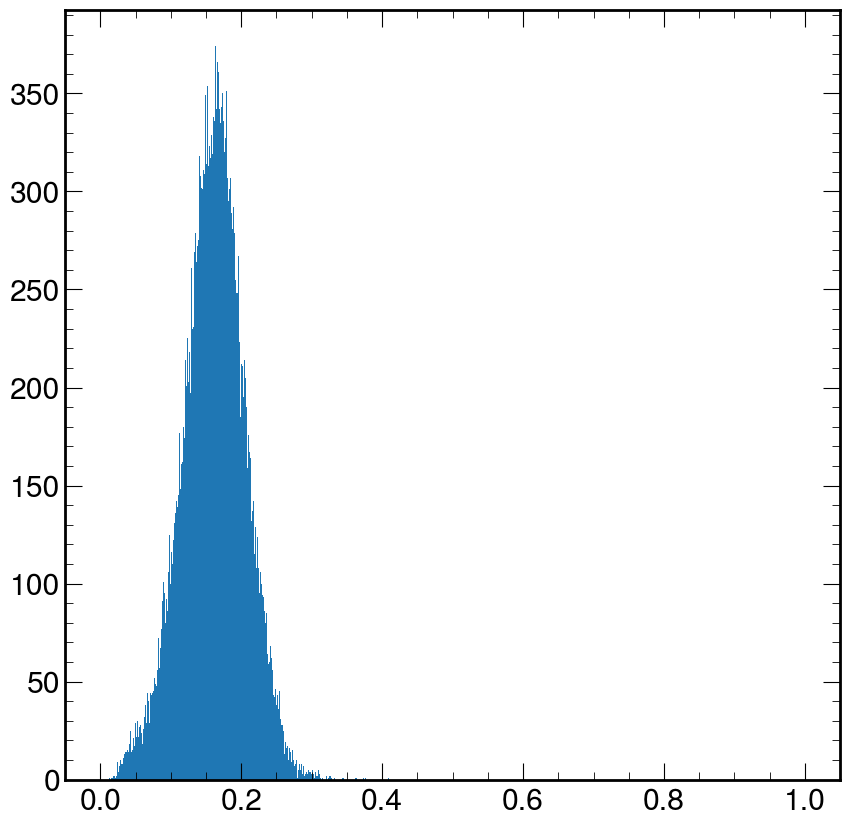

In [68]:
h = plt.hist(classifier.predict(PHSP[cols]), bins=1000, range=[0,1])
#plt.hist(classifier2.predict_proba(PHSP[cols])[:,1], bins=h[1], histtype='step')
plt.show()

prob1 = classifier.predict_proba(PHSP[cols])[:,1]
prob2 = classifier2.predict_proba(PHSP[cols])[:,1]
h = plt.hist(prob1 - prob2, bins=1000, range=[0,1])
plt.show()

In [69]:
new_weights = classifier.predict(PHSP[cols])/(1-classifier.predict(PHSP[cols]))

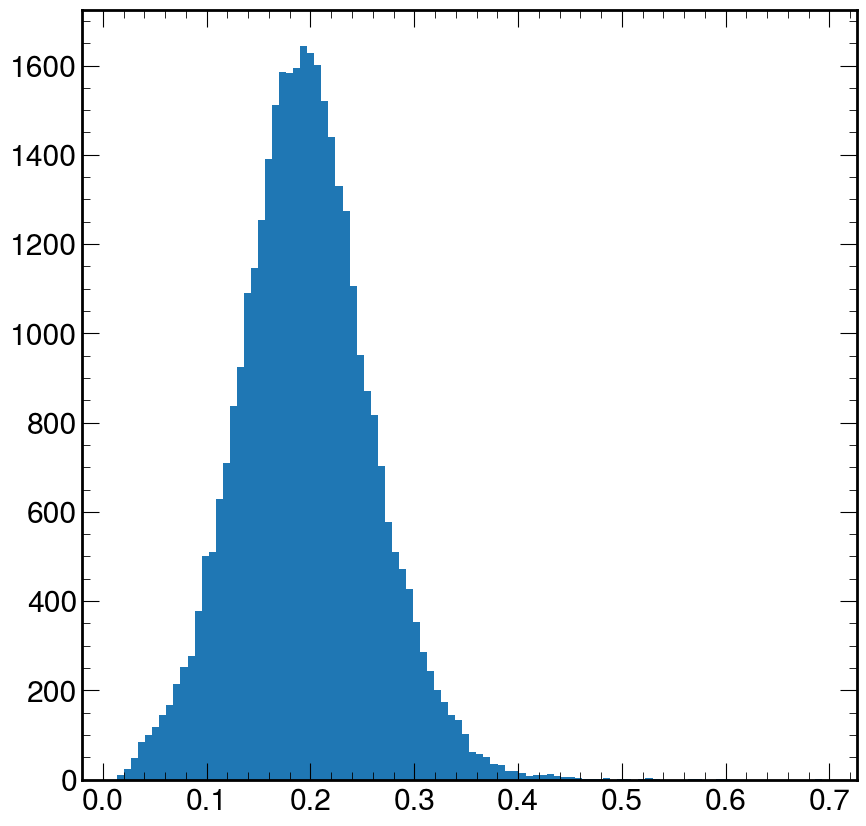

In [70]:
plt.hist(new_weights, bins=100)
plt.show()

In [71]:
cols

['mu1_pt', 'mu2_pt', 'kpt', 'cosA', 'fit_eta', 'mu1_IP_sig', 'mu2_IP_sig']

Overflow  (>=158.107)
	 1.0 +- 1.0
	Unweighted  1 

Underflow (<7.003)
	 1.02 +- 1.25
	Unweighted  2 



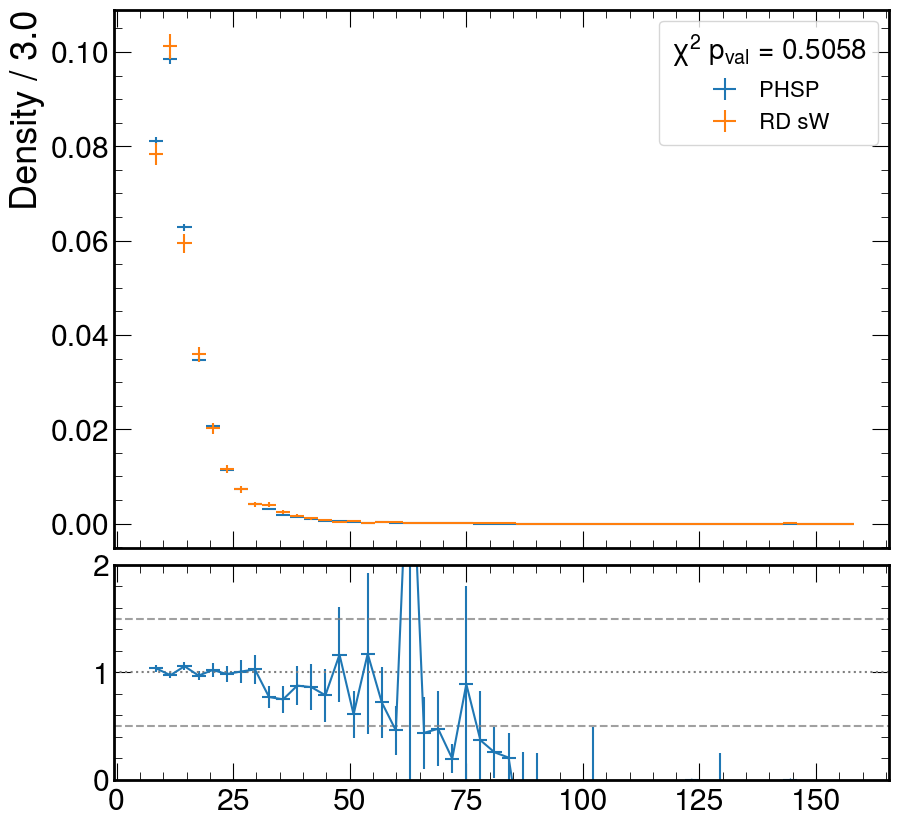

In [72]:
var = cols[0]
plot_tools.compare_plot(PHSP[var], 
                        RD[var], 
                        weights_Den=RD.sW, label_Den='RD sW', label_Num='PHSP')

Overflow  (>=158.107)
	 1.0 +- 1.0
	Unweighted  1 

Underflow (<7.003)
	 1.02 +- 1.25
	Unweighted  2 

Overflow  (>=69.957)
	 1.0 +- 1.0
	Unweighted  1 

Overflow  (>=134.995)
	 1.0 +- 1.0
	Unweighted  1 

Overflow  (>=134.995)
	 1.06 +- 1.06
	Unweighted  1 

Overflow  (>=1.0)
	 195.0 +- 13.96
	Unweighted  195 

Overflow  (>=1.0)
	 18.29 +- 5.07
	Unweighted  36 

Overflow  (>=2.429)
	 1.0 +- 1.0
	Unweighted  1 

Underflow (<-2.406)
	 0.59 +- 1.24
	Unweighted  4 

Overflow  (>=2.429)
	 0.97 +- 1.12
	Unweighted  2 

Overflow  (>=288.859)
	 1.0 +- 1.0
	Unweighted  1 

Overflow  (>=321.086)
	 1.0 +- 1.0
	Unweighted  1 



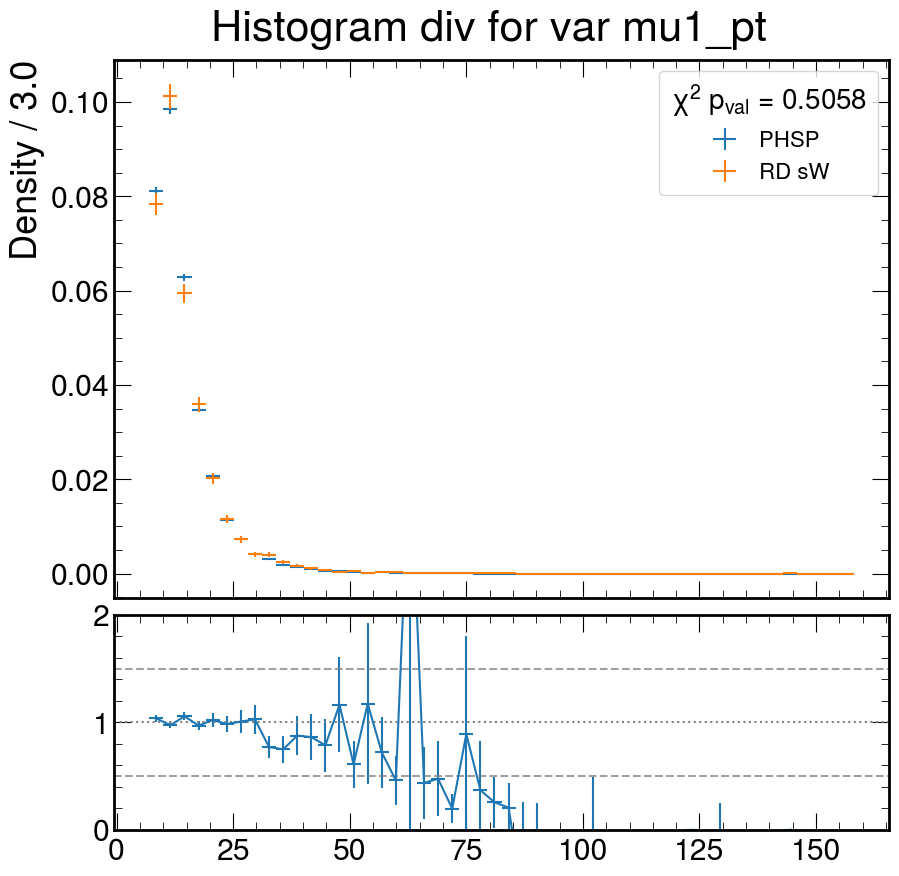

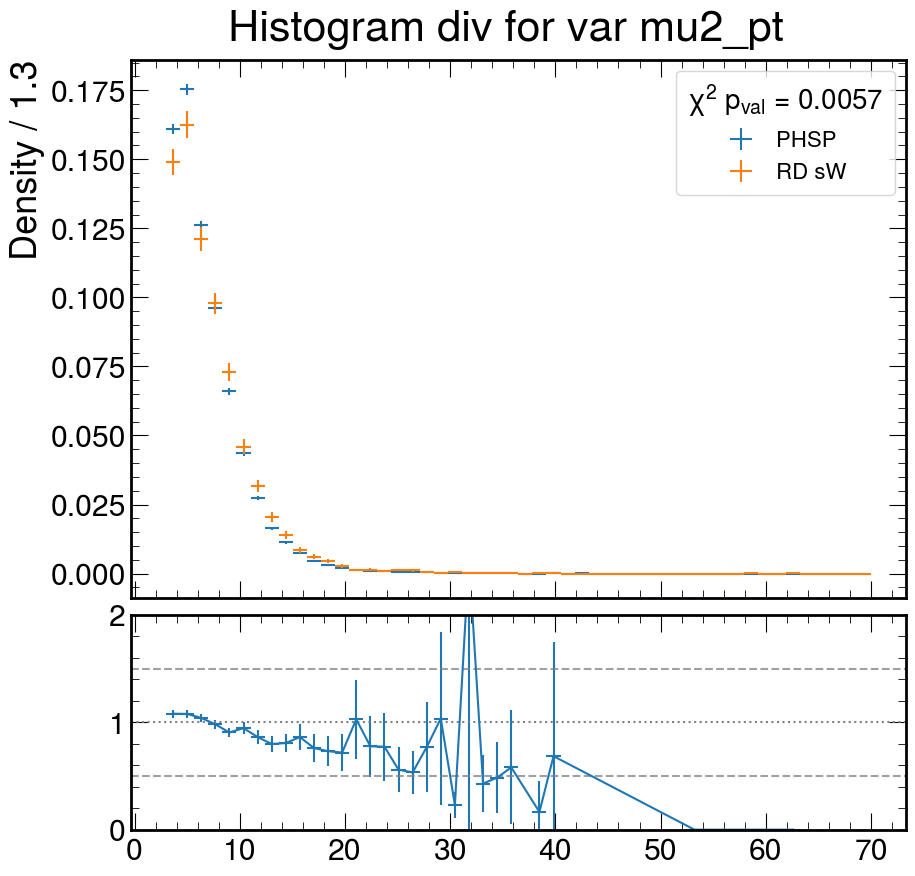

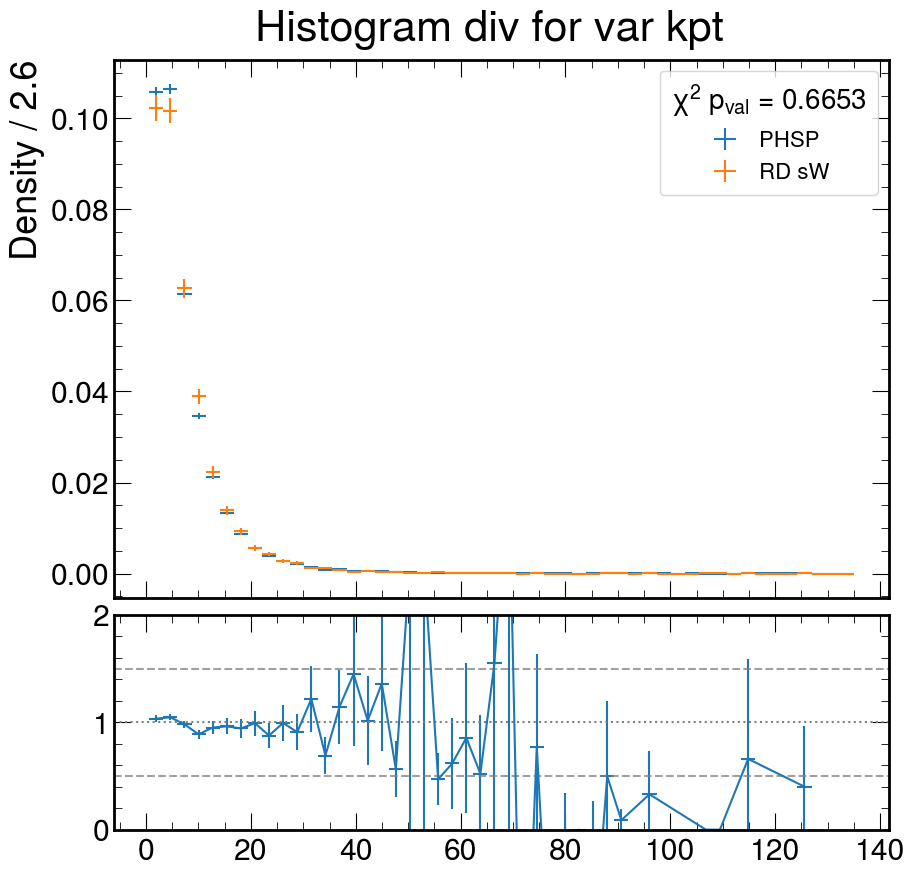

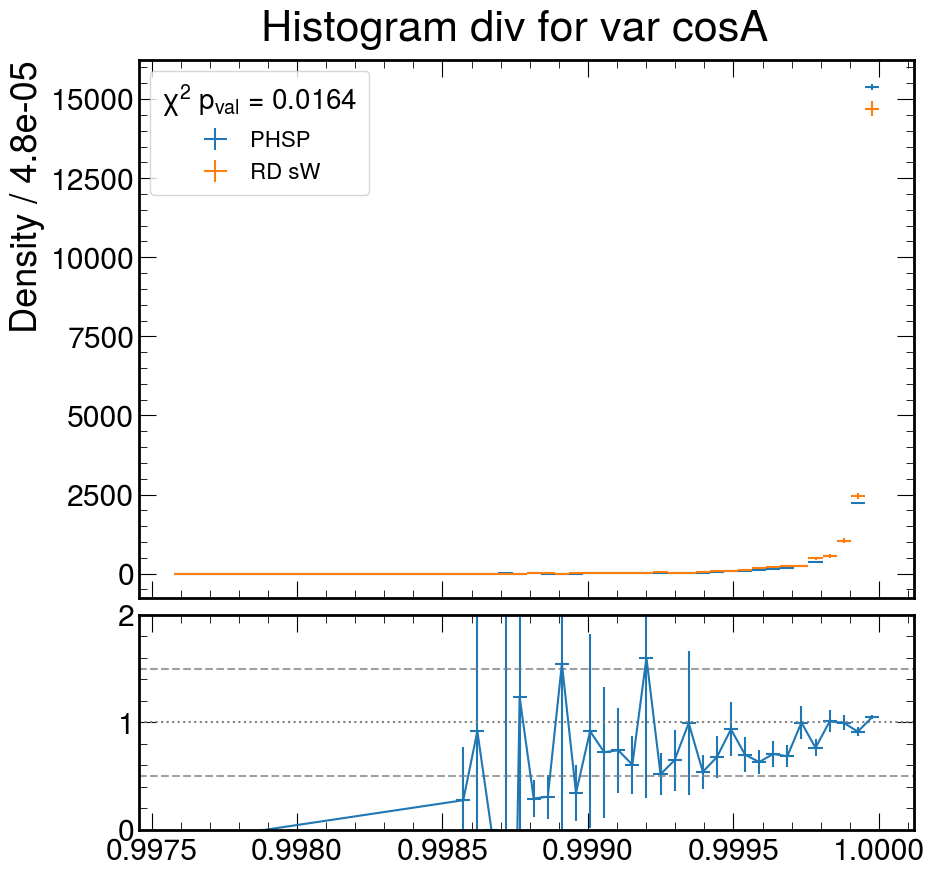

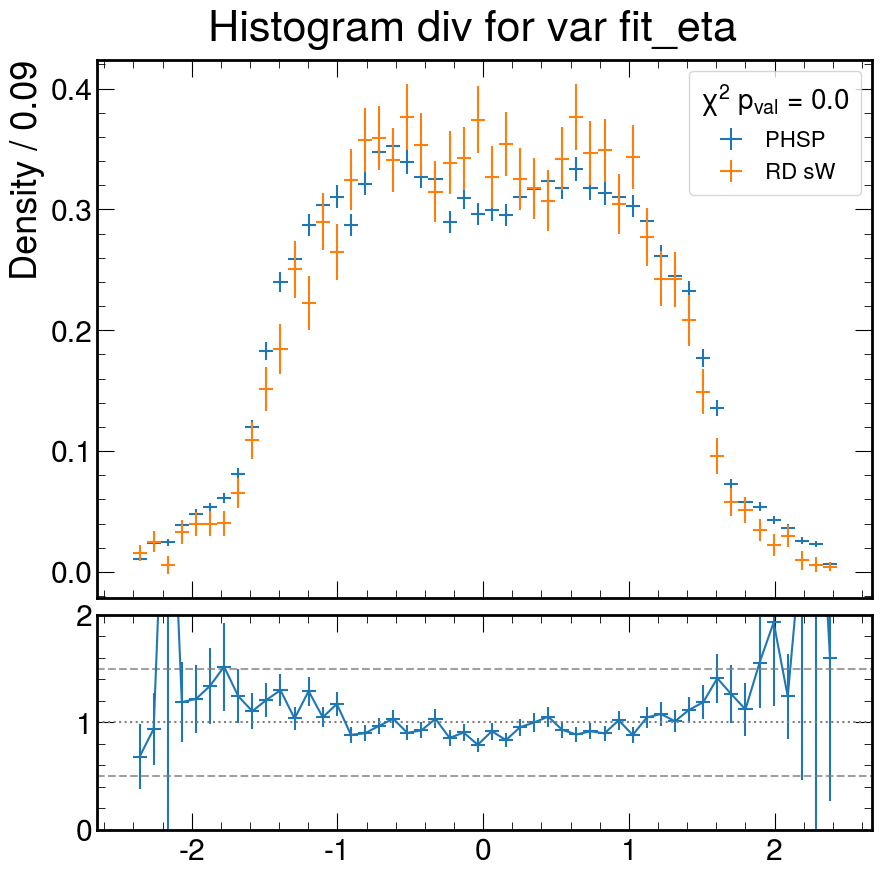

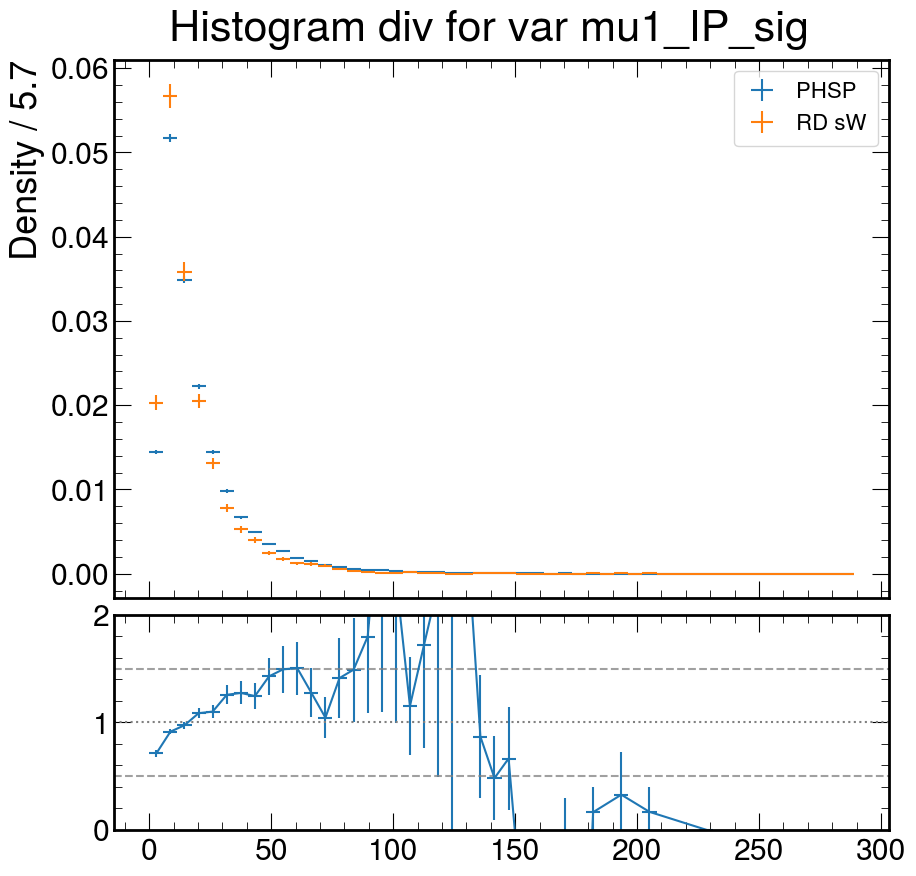

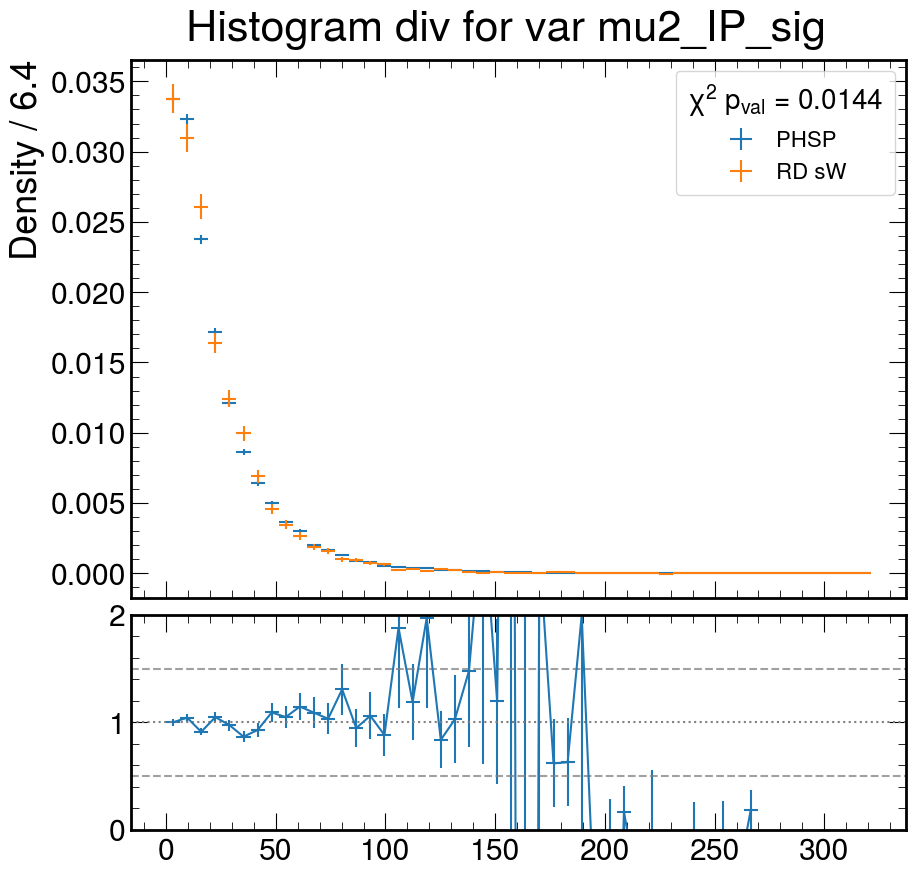

In [73]:
for col in cols:
    plot_tools.compare_plot(PHSP[col], 
                        RD[col], 
                        weights_Den=RD.sW,
                        label_Den='RD sW', label_Num='PHSP', title="Histogram div for var " + col)

Overflow  (>=158.107)
	 0.25 +- 0.25
	Unweighted  1 

Underflow (<7.003)
	 1.02 +- 1.25
	Unweighted  2 

Overflow  (>=69.957)
	 0.34 +- 0.34
	Unweighted  1 

Overflow  (>=134.995)
	 0.18 +- 0.18
	Unweighted  1 

Overflow  (>=134.995)
	 1.06 +- 1.06
	Unweighted  1 

Overflow  (>=1.0)
	 19.64 +- 1.56
	Unweighted  195 

Overflow  (>=1.0)
	 18.29 +- 5.07
	Unweighted  36 

Overflow  (>=2.429)
	 0.04 +- 0.04
	Unweighted  1 

Underflow (<-2.406)
	 0.59 +- 1.24
	Unweighted  4 

Overflow  (>=2.429)
	 0.97 +- 1.12
	Unweighted  2 

Overflow  (>=288.859)
	 0.16 +- 0.16
	Unweighted  1 

Overflow  (>=321.086)
	 0.07 +- 0.07
	Unweighted  1 



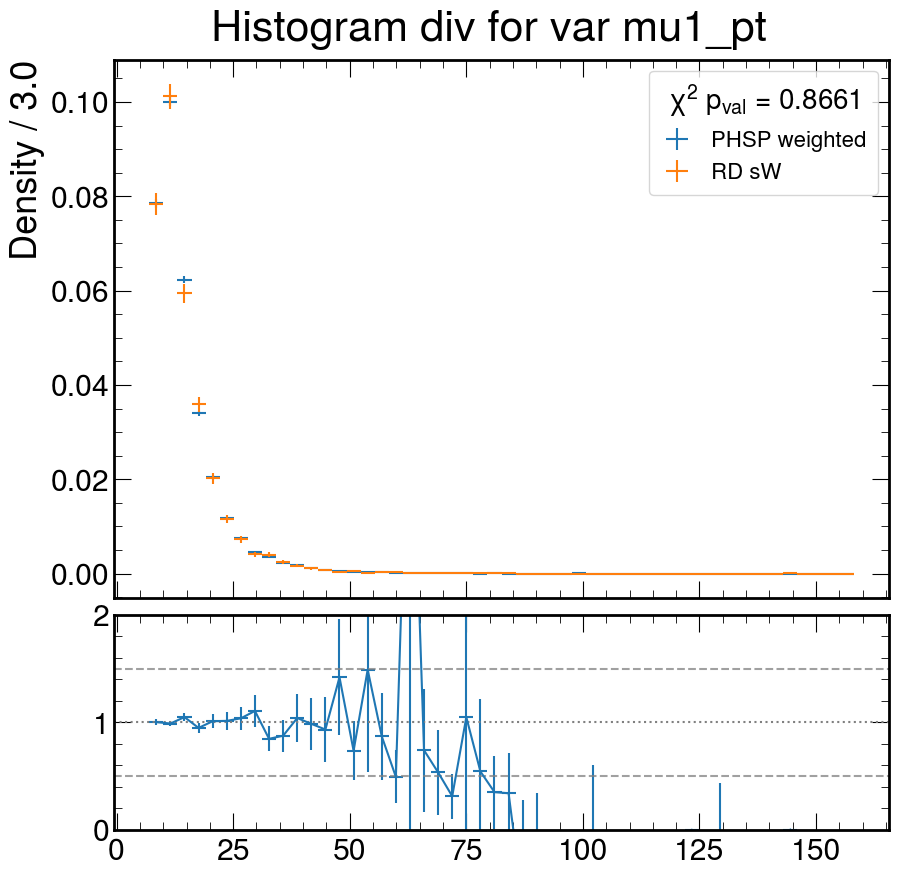

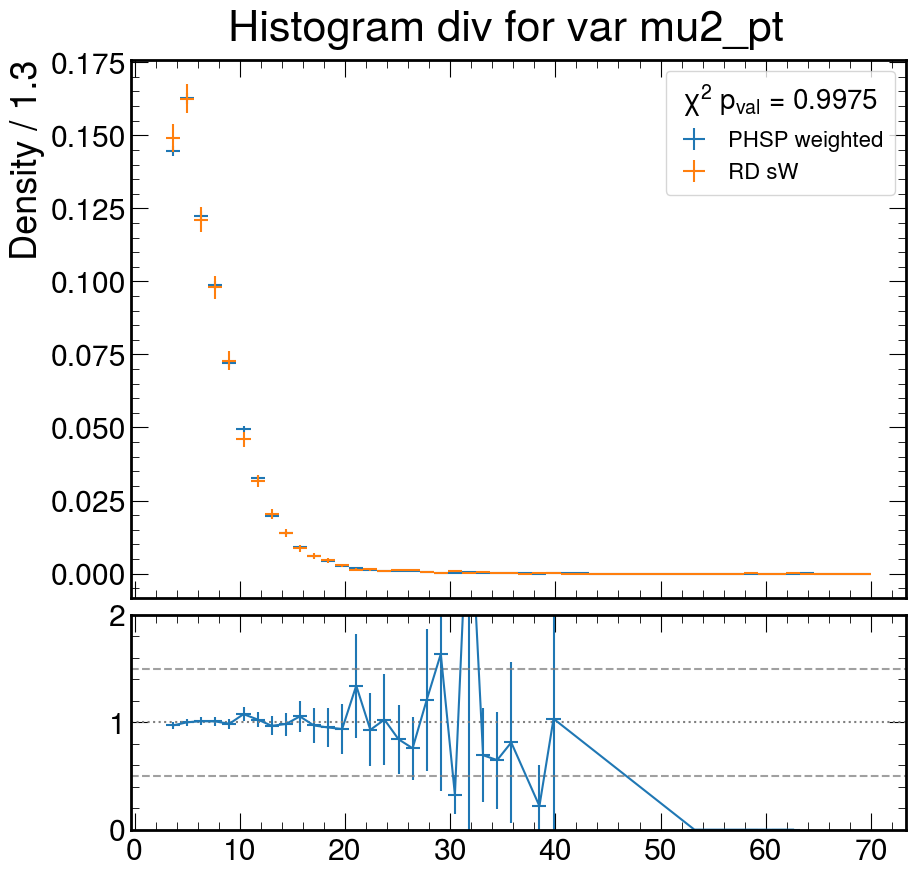

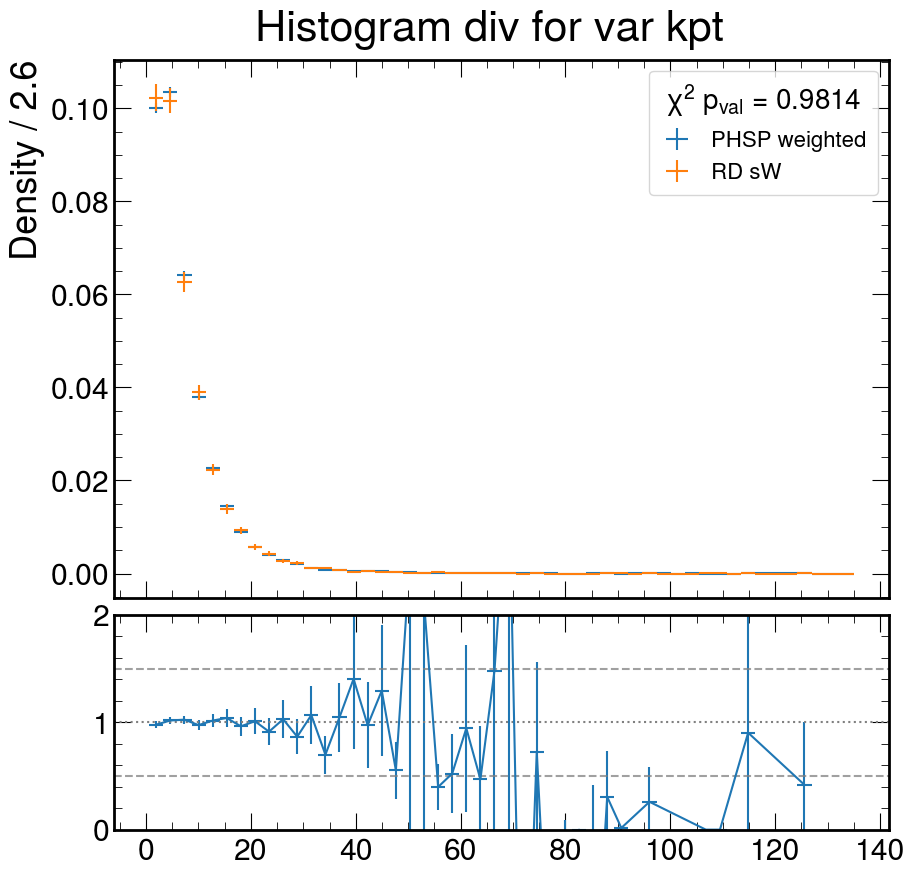

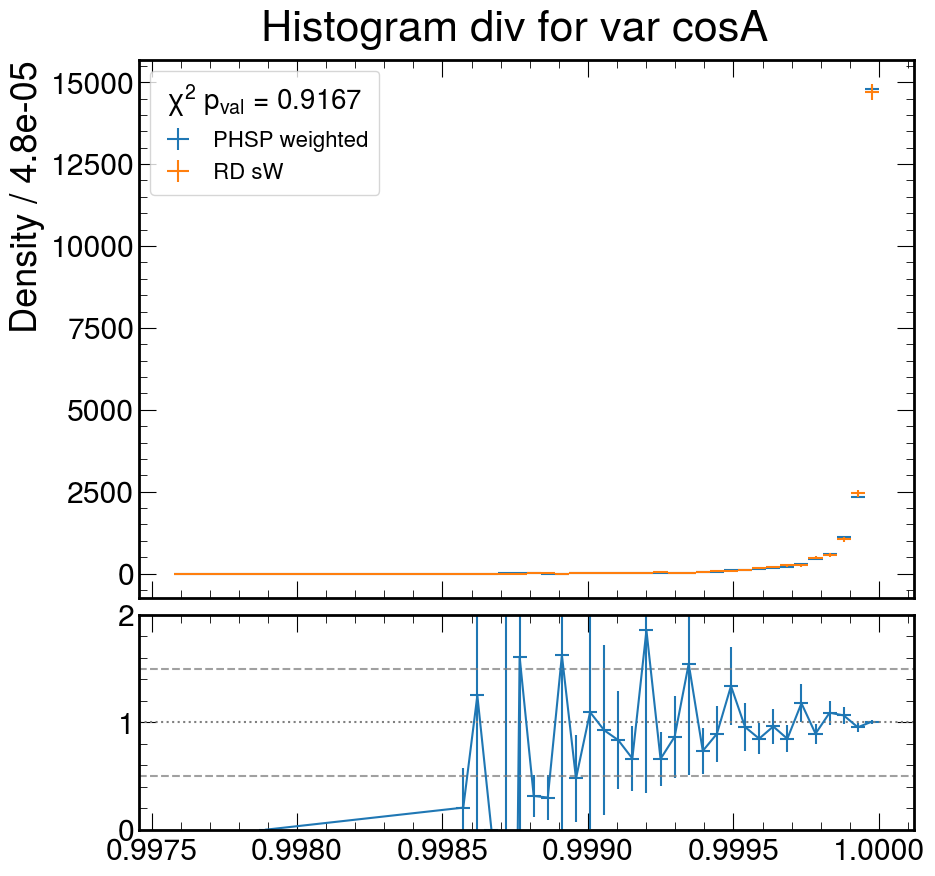

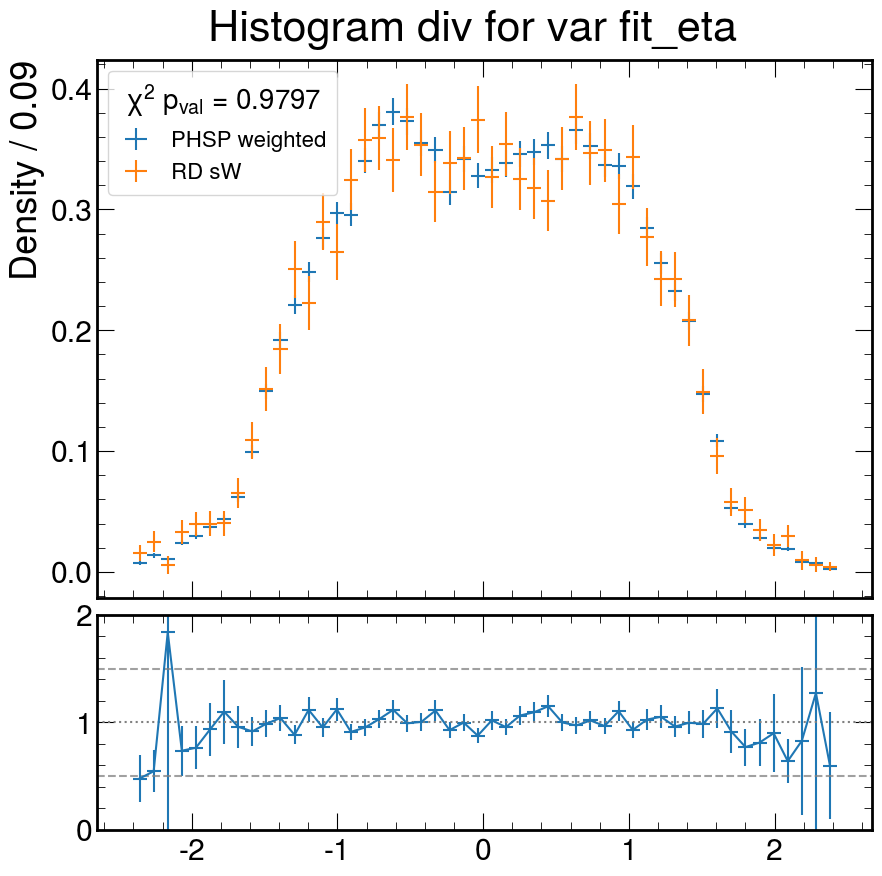

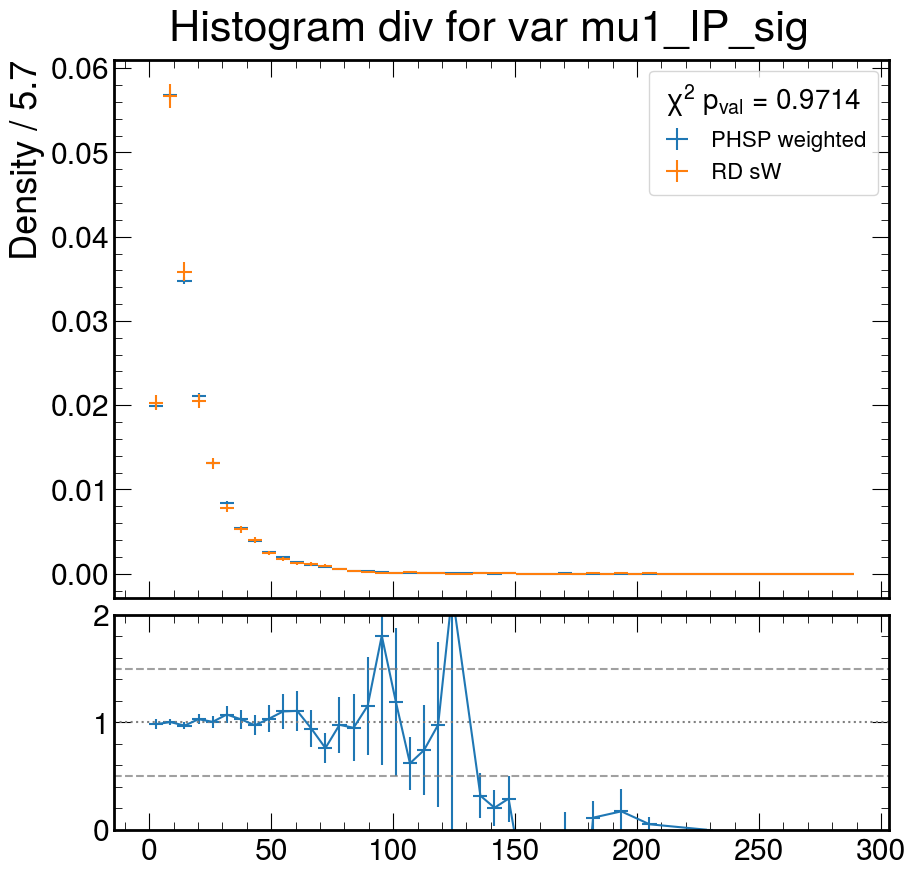

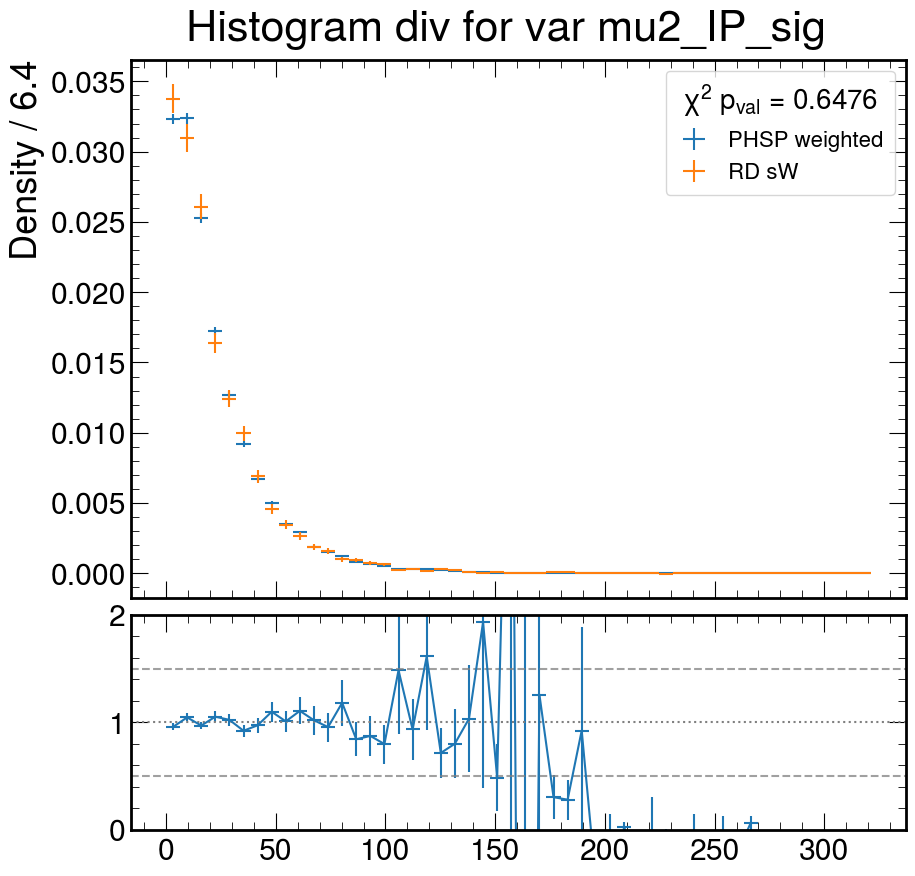

In [74]:
for col in cols:
    plot_tools.compare_plot(PHSP[col], 
                        RD[col], 
                        weights_Den=RD.sW,
                        weights_Num=new_weights,
                        label_Den='RD sW', label_Num='PHSP weighted', title="Histogram div for var " + col)

classifier = xgb.XGBClassifier()
classifier.fit(X=dataFrame[cols], 
               y=dataFrame.label, 
               sample_weight=dataFrame['sW'])

In [75]:
# var = cols
# for col in cols:
#     distance = ks_2samp_weighted(RD[col],
#                             PHSP[col],
#                             RD['sW'],
#                             new_weights)
#     print("col:",cols[1], ", x2=", distance[1] )

# Reweighting analysis

# Iterative Reweighting

In [76]:
# Hyperparameter search